# ML Training and Optimization

## Introduction

This notebook is dependent on the execution of `scripts/03 - data_preprocessing.py`

## Imports and Definitions

In [2]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
import yaml
import os

# ML imports
from sklearn.model_selection import train_test_split

print("Defining Classes")

class Logger:
    def __init__(self, config):
        self.config = config
        self.log_dir = config['logging']['out_dir']
        self.tag = config['base']['tag']
        self.file_path = os.path.join('outputs', self.tag, self.log_dir, 'log.txt')
        self.verbose = config['logging']['verbose']
        
    def log(self, message):
        current_datetime = datetime.datetime.now()
        datetime_string = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
        log_message = f"{datetime_string}: {message}"
        if self.verbose:
            print(log_message)
        with open(self.file_path, "a") as f:
            f.write(f'{log_message}\n')

print("Defining Functions")

def loan_status_to_int(status):
    if status == 'Charged Off':
        return 0
    if status == 'Fully Paid':
        return 1
    else:
        return -1

def bestbandwidth(data):
    return 1.06*np.std(data)*len(data)**(-1/5)

def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return f"Created directory: {directory}"
    else:
        return f"Directory already exists: {directory}"

def transform_type(sqlite_type):
    if sqlite_type == 'INTEGER':
        return 'int'
    if sqlite_type == 'REAL':
        return 'float'
    if sqlite_type == 'TEXT':
        return 'object'

def map_dtype_to_sqlite(col_type):
    if col_type.startswith('int') or col_type == 'bool':
        return 'INTEGER'
    elif col_type.startswith('float'):
        return 'REAL'
    else:  # Default case, particularly for 'object' and other unhandled types
        return 'TEXT'

print("Reading Config File")

config_file_path = '../config/config.yml'

root_path = '..'

print(f"Reading Config File {config_file_path}")
with open(config_file_path, 'r') as f:
    config = yaml.safe_load(f)

print("Defining Variables and Creating Directories")

sqlite_file = config['data']['output_sqlite']

tag = config['base']['tag']

git_repo = config['base']['git_repo']

fontsize = config['plotting']['fontsize']
figsize_x = config['plotting']['figure_xsize']
figsize_y = config['plotting']['figure_ysize']

optimization_sample_size = config['machine_learning']['optimization_sample_size']

out_dir_figures = f"outputs/{tag}/figures"
out_dir_stats = f"outputs/{tag}/stats"
out_dir_log = f"outputs/{tag}/log"
out_dir_models = f"outputs/{tag}/models"

sqlite_file = os.path.join(f'{root_path}/outputs/{tag}/data/{sqlite_file}')
out_dir_figures = os.path.join(root_path, out_dir_figures)
out_dir_stats = os.path.join(root_path, out_dir_stats)
out_dir_log = os.path.join(root_path, out_dir_log)
out_dir_models = os.path.join(root_path, out_dir_log)

columns_of_interest = config['base']['columns_of_interest']

print("Done with initial setup")

Defining Classes
Defining Functions
Reading Config File
Reading Config File ../config/config.yml
Defining Variables and Creating Directories
Done with initial setup


## Loading Full and Sample Data

In [67]:
print("Loading Data")
# Defining the connection to the database
conn = sqlite3.connect(sqlite_file)

# Loading descriptions into dataframe
description_fetch_query = f"""SELECT *
                    FROM descriptions
                    """
descriptions = pd.read_sql_query(description_fetch_query, conn, index_col='name')

# Loading data into dataframe
data_fetch_query = f"""SELECT * 
                       FROM loans_data_ML
                       ORDER BY RANDOM()"""

loans_data = pd.read_sql_query(data_fetch_query, conn, index_col='id')

# Closing connection
conn.close()

print("Separating sample data for ML hyperparameter optimization")

sample_data = loans_data.sample(optimization_sample_size)

print("Done with Loading Full and Sample Data")

Loading Data
Separating sample data for ML hyperparameter optimization
Done with Loading Full and Sample Data


## Machine Learning Hyperparameter Optimization and Full Training

In [68]:
import sys
import os
import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    # Since we're setting this at the sys level, it should not be overridden
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

    
X_opt, y_opt = sample_data.drop('loan_status', axis='columns').values, sample_data['loan_status'].values

X, y = loans_data.drop('loan_status', axis='columns').values, loans_data['loan_status'].values

ML_columns = loans_data.drop('loan_status', axis='columns').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

Through exploration we find that:
 - `solver = 'lbfgs'`
   - `C < 1e-6` causes an overfit, where the model only predicts defaults
   - Optimal `C` seems to be any value above 1e-5. giving around 56% accuracy.
 - `solver = 'liblinear'`
   - `l2` penalty is much faster than `l1`
   - Plateaus around `C 1e-2`, not much change if fitting time
   - Best accuract around ~65%
 - `solver = 'sag'`
   - 

In [23]:
cummulative_results = None

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV, learning_curve
from IPython.display import clear_output
    
logistic_regression = LogisticRegression(class_weight='balanced', max_iter = 1000000)

scoring = {
    'accuracy': 'accuracy',  # Default scorer
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

allowed_penalties = {
    'lbfgs': ['l2'],
    'liblinear': ['l2'],
    'newton-cg': ['l2']
}

for i, solver in enumerate(allowed_penalties.keys()):
    print(f"Optimizing for {solver} | {i}/{len(allowed_penalties.keys())}")
    param_grid = {
        'C': np.logspace(-10, 10, num = 50),
        'solver': [solver],
        'penalty': allowed_penalties[solver]
        }
    grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, verbose=10, scoring=scoring, refit='f1_score')

    grid_search.fit(X_opt, y_opt)

    clear_output(wait=True)

    results = pd.DataFrame(grid_search.cv_results_)
    results['ML_model'] = ["LogisticRegression"]*len(results)
    if cummulative_results is None:
        cummulative_results = results.copy()
    else:
        cummulative_results = pd.concat([cummulative_results, results])

for param in ['C', 'solver', 'penalty']:
    cummulative_results[f'param_{param}'] = [row['params'][param] for _, row in cummulative_results.iterrows()]

fig, ax = plt.subplots(5, figsize=[10, 25/1.62])

best_bw_time = bestbandwidth(cummulative_results['mean_fit_time'])
min_time, max_time = cummulative_results['mean_fit_time'].min(), cummulative_results['mean_fit_time'].max()
nBins_time = int((max_time - min_time)/best_bw_time)
bins_time = np.linspace(min_time, max_time, num = nBins_time)

for solver in cummulative_results['param_solver'].unique():
    for penalty in cummulative_results['param_penalty'].unique():
        label = f'Solver: {solver}, Penalty: {penalty}'
        mask_solver = cummulative_results['param_solver'].apply(lambda x: str(x) == solver)
        mask_panelty = cummulative_results['param_penalty'].apply(lambda x: str(x) == penalty)
        results_temp = cummulative_results[mask_solver & mask_panelty]
        
        Cs = results_temp['param_C']
        mean_scores = results_temp['mean_test_accuracy']
        std_scores = results_temp['std_test_accuracy']
        ax[0].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[0].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        mean_scores = results_temp['mean_test_precision']
        std_scores = results_temp['std_test_precision']
        ax[1].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[1].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        mean_scores = results_temp['mean_test_recall']
        std_scores = results_temp['std_test_recall']
        ax[2].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[2].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        mean_scores = results_temp['mean_test_f1_score']
        std_scores = results_temp['std_test_f1_score']
        ax[3].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[3].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        ax[4].hist(results_temp['mean_fit_time'], alpha=0.1, edgecolor = 'k', bins=bins_time, label=label)

        clear_output()

ax[0].set_xscale('log')
ax[0].set_xlabel('C (Inverse of Regularization Strength)')
ax[0].set_ylabel('Mean Accuracy Score')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('C (Inverse of Regularization Strength)')
ax[1].set_ylabel('Mean Precision Score')
ax[1].legend()

ax[2].set_xscale('log')
ax[2].set_xlabel('C (Inverse of Regularization Strength)')
ax[2].set_ylabel('Mean Recall Score')
ax[2].legend()

ax[3].set_xscale('log')
ax[3].set_xlabel('C (Inverse of Regularization Strength)')
ax[3].set_ylabel('Mean F1 Score')
ax[3].legend()

ax[4].set_xlabel("Fitting Time (s)")
ax[4].set_ylabel('Count')
ax[4].legend()

fig.tight_layout()

Optimizing for saga | 0/1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 1/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.540) f1_score: (test=0.346) precision: (test=0.241) recall: (test=0.612) total time=   9.7s
[CV 2/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 2/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.509) f1_score: (test=0.353) precision: (test=0.239) recall: (test=0.675) total time=   8.0s
[CV 3/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 3/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.534) f1_score: (test=0.358) precision: (test=0.247) recall: (test=0.654) total time=   8.0s
[CV 4/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 4/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.508) f1_score: (test=0.

KeyboardInterrupt: 

In [18]:
cummulative_results = cummulative_results.replace('None', 'none')

In [25]:
cummulative_results.sort_values('mean_test_f1_score', inplace=True)
cummulative_results.dropna(inplace=True)
print("Loading best parameters and defining")
# Initialize the model
best_C = cummulative_results.iloc[-1]['param_C']
best_solver = cummulative_results.iloc[-1]['param_solver']
best_penalty = cummulative_results.iloc[-1]['param_penalty']

print(f"Best Parameters: \nC: {best_C}\nsolver: {best_solver}\npenalty {best_penalty}")
logistic_model = LogisticRegression(class_weight='balanced',
                                    max_iter=100000,
                                    C=best_C, 
                                    solver=best_solver,
                                    penalty=best_penalty)

print("Fitting the model to the training data")
# Train the model
logistic_model.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = logistic_model.predict(X_test)

print("Computing cross-validations")
train_sizes, train_scores, test_scores = learning_curve(
    logistic_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 10),
    verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

coefficients = np.abs(logistic_model.coef_[0])

# Combining feature names and their corresponding coefficients
features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

features = np.array(features)
coefs = np.array(coefs)

features = features[coefs > 0]
coefs = coefs[coefs > 0]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")


sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
ax[2].set_title("Correlation between Loan status and Numeric Features")
ax[2].set_xlabel('Correlation')
ax[2].set_ylabel('Numerical Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

Loading best parameters and defining
Best Parameters: 
C: 0.2442053094548655
solver: newton-cg
penalty l2
Fitting the model to the training data
Making predictions with the fit model
Computing cross-validations
[learning_curve] Training set sizes: [ 86099 172199 258299 344399 430499 516598 602698 688798 774898 860998]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed: 51.8min remaining: 811.0min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 88.6min remaining: 403.6min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 111.9min remaining: 261.1min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 137.6min remaining: 190.1min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 153.9min remaining: 131.1min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 182.3min remaining: 93.9min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 201.4min remaining: 56.8min


[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time= 5.3min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.633, test=0.633) total time= 8.9min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.636) total time=20.1min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.634) total time=47.7min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.636) total time= 5.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.636) total time=18.8min
[CV] START .................

[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 232.8min remaining: 25.9min


[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time=69.3min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.636) total time=34.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.637) total time=37.6min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.638) total time=33.9min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time=30.9min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.634) total time=22.9min
[CV] START .................

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 244.6min finished


Computing mean scores


NameError: name 'accuracy_score' is not defined

[CV] START .....................................................................
[CV] END ..................., score=(train=0.641, test=0.640) total time= 3.7min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.638, test=0.637) total time= 8.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.637, test=0.637) total time=24.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time=55.6min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.636) total time=30.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.636) total time=18.9min
[CV] START .................

In [32]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix


### Random Forest

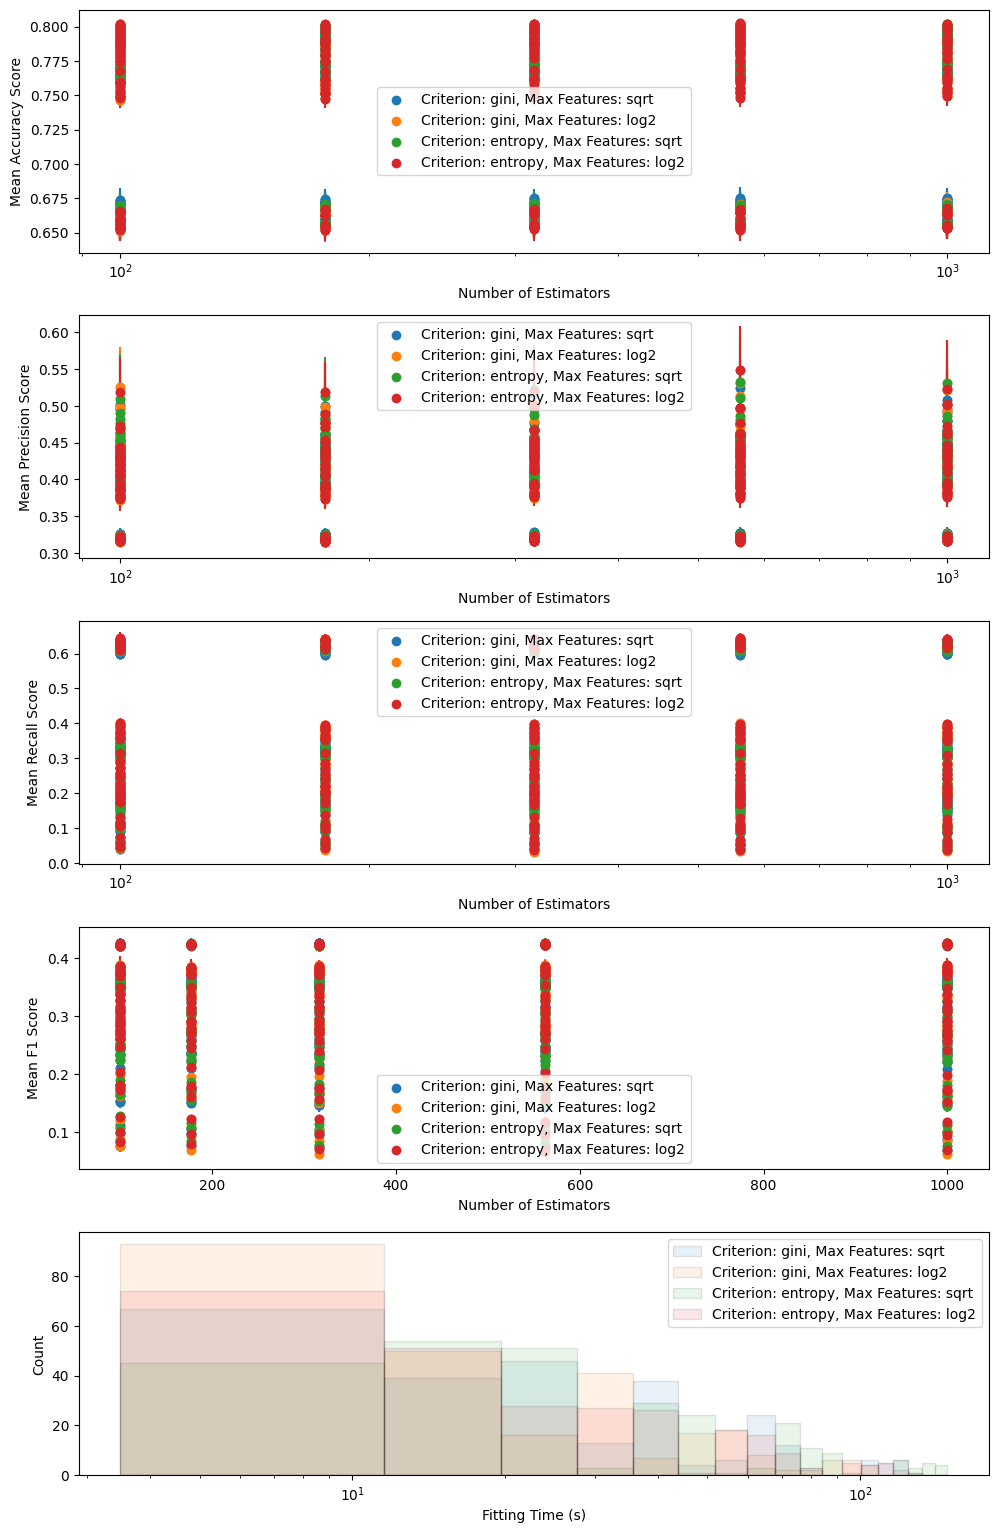

In [62]:
from sklearn.ensemble import RandomForestClassifier
    
random_forest_classifier = RandomForestClassifier(class_weight='balanced')

scoring = {
    'accuracy': 'accuracy',  # Default scorer
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

param_grid = {
    'n_estimators': [int(i) for i in np.logspace(2, 3, 5)],  # Fewer, more spaced out values
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"],  # Adding a fraction
    'max_depth': [None, 10, 30, 50],  # None means fully grown trees
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid,
                           cv=5,
                           verbose=10,
                           scoring=scoring,
                           refit='recall',
                           n_jobs=-1)

grid_search.fit(X_opt, y_opt)

clear_output(wait=True)

results = pd.DataFrame(grid_search.cv_results_)
results['ML_model'] = ["RandomForestClassifier"]*len(results)

for param in ['n_estimators', 'criterion', 'max_features']:
    results[f'param_{param}'] = [row['params'][param] for _, row in results.iterrows()]

if cummulative_results is None:
    cummulative_results = results.copy()
else:
    cummulative_results = pd.concat([cummulative_results, results])

fig, ax = plt.subplots(5, figsize=[10, 25/1.62])

best_bw_time = bestbandwidth(results['mean_fit_time'])
min_time, max_time = results['mean_fit_time'].min(), results['mean_fit_time'].max()
nBins_time = int((max_time - min_time)/best_bw_time)
bins_time = np.linspace(min_time, max_time, num = nBins_time)

for criterion in results['param_criterion'].dropna().unique():
    for max_features in results['param_max_features'].dropna().unique():
        label = f'Criterion: {criterion}, Max Features: {max_features}'
        mask_criterion = results['param_criterion'].apply(lambda x: str(x) == criterion)
        mask_max_features = results['param_max_features'].apply(lambda x: str(x) == max_features)
        results_temp = results[mask_criterion & mask_max_features].dropna()

        n_estimators = results_temp['param_n_estimators']
        mean_scores = results_temp['mean_test_accuracy']
        std_scores = results_temp['std_test_accuracy']
        ax[0].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[0].scatter(n_estimators, mean_scores, label=label)

        mean_scores = results_temp['mean_test_precision']
        std_scores = results_temp['std_test_precision']
        ax[1].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[1].scatter(n_estimators, mean_scores, label=label)

        mean_scores = results_temp['mean_test_recall']
        std_scores = results_temp['std_test_recall']
        ax[2].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[2].scatter(n_estimators, mean_scores, label=label)

        mean_scores = results_temp['mean_test_f1_score']
        std_scores = results_temp['std_test_f1_score']
        ax[3].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[3].scatter(n_estimators, mean_scores, label=label)

        ax[4].hist(results_temp['mean_fit_time'], alpha=0.1, edgecolor = 'k', bins=bins_time, label=label)

        clear_output()

ax[0].set_xscale('log')
ax[0].set_xlabel('Number of Estimators')
ax[0].set_ylabel('Mean Accuracy Score')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('Number of Estimators')
ax[1].set_ylabel('Mean Precision Score')
ax[1].legend()

ax[2].set_xscale('log')
ax[2].set_xlabel('Number of Estimators')
ax[2].set_ylabel('Mean Recall Score')
ax[2].legend()

ax[4].set_xscale('log')
ax[3].set_xlabel('Number of Estimators')
ax[3].set_ylabel('Mean F1 Score')
ax[3].legend()

ax[4].set_xlabel("Fitting Time (s)")
ax[4].set_ylabel('Count')
ax[4].legend()

fig.tight_layout()

Loading best parameters and defining
Best Parameters: 
 - N Estimators: 100
 - Criterion: entropy
 - Max_Features log2
Fitting the model to the training data
Making predictions with the fit model
Computing mean scores
Accuracy: 0.6315533222825965
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    215639
           1       0.31      0.68      0.42     53423

    accuracy                           0.63    269062
   macro avg       0.60      0.65      0.58    269062
weighted avg       0.77      0.63      0.67    269062

Making Plots


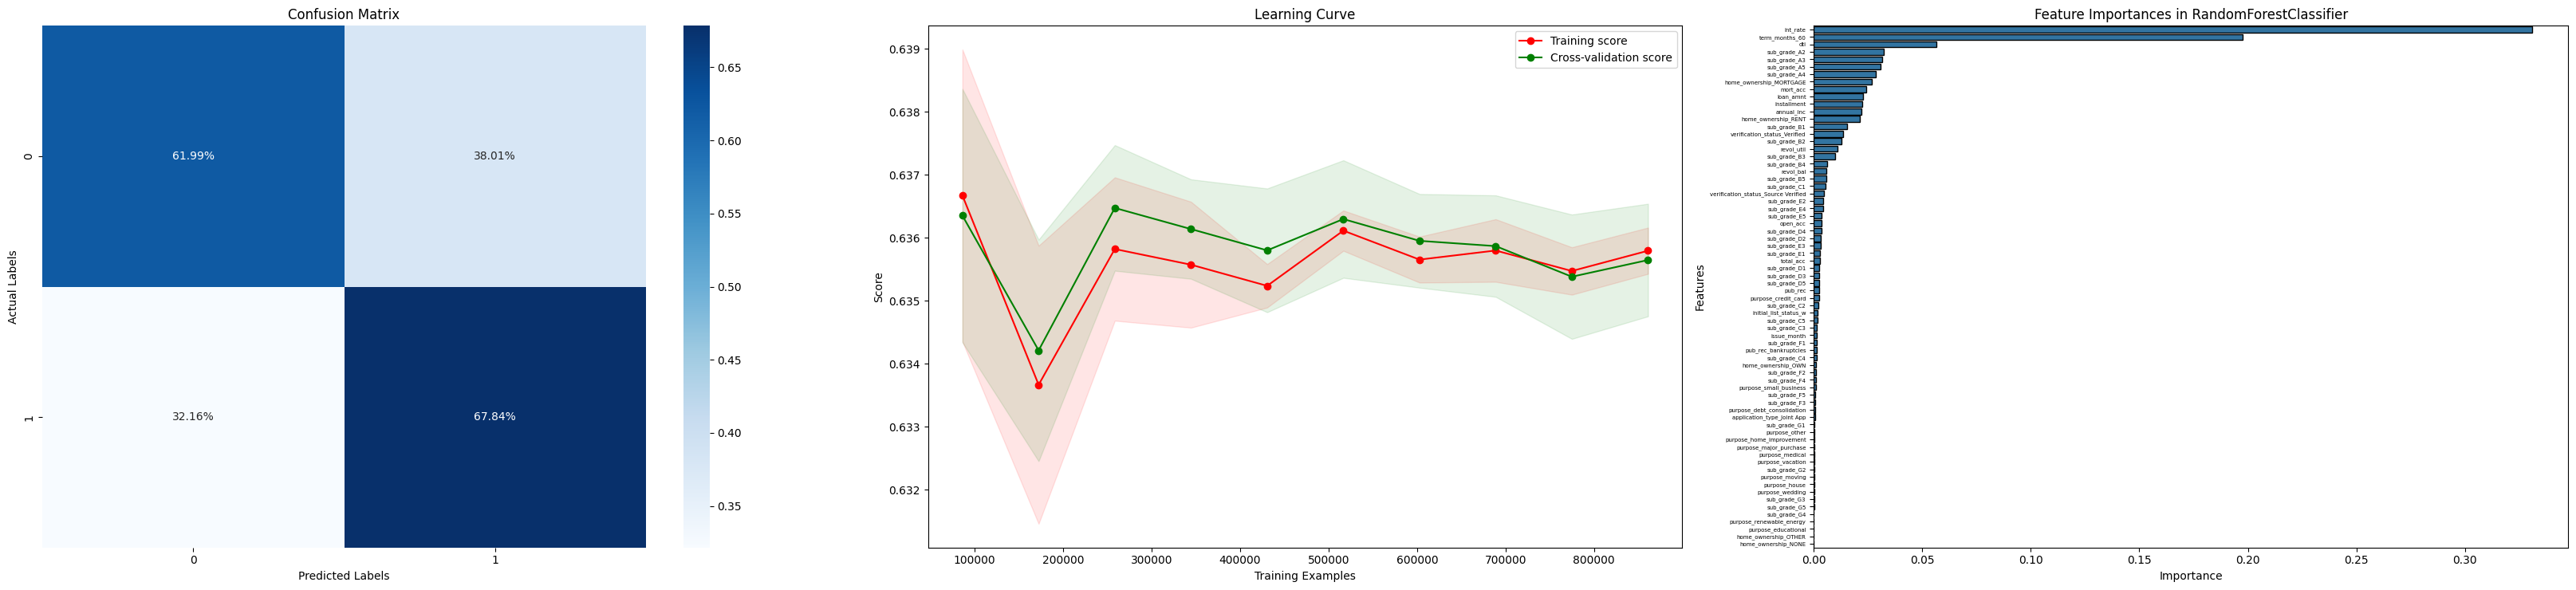

In [65]:
results.sort_values('mean_test_recall', inplace=True)
results.dropna(inplace=True)
print("Loading best parameters and defining")
# Initialize the model
best_n_estimators = results.iloc[-1]['param_n_estimators']
best_criterion = results.iloc[-1]['param_criterion']
best_max_features = results.iloc[-1]['param_max_features']
best_max_depth = results.iloc[-1]['param_max_depth']
best_min_samples_split = results.iloc[-1]['param_min_samples_split']
best_min_samples_leaf = results.iloc[-1]['param_min_samples_leaf']
best_bootstrap = results.iloc[-1]['param_bootstrap']

print(f"""Best Parameters:
 - N Estimators: {best_n_estimators}
 - Criterion: {best_criterion}
 - Max_Features {best_max_features}
 - Max Depth {best_max_depth}
 - """)
random_forest_classifier = RandomForestClassifier(class_weight='balanced',
                                    n_estimators=best_n_estimators, 
                                    criterion=best_criterion,
                                    max_features=best_max_features,
                                    max_depth=best_max_depth,
                                    min_samples_split=best_min_samples_split,
                                    min_samples_leaf=best_min_samples_leaf,
                                    bootstrap=best_bootstrap)

print("Fitting the model to the training data")
# Train the model
random_forest_classifier.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = random_forest_classifier.predict(X_test)

# print("Computing cross-validations")
# train_sizes, train_scores, test_scores = learning_curve(
#     random_forest_classifier, X, y, cv=5, n_jobs=-1, 
#     train_sizes=np.linspace(.1, 1.0, 10),
#     verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

feature_importances = random_forest_classifier.feature_importances_

features = np.array(ML_columns)  # Assuming ML_columns are your feature names
importances = feature_importances

# Sorting features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=sorted_importances, y=sorted_features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances in RandomForestClassifier")
ax[2].set_xlabel('Importance')
ax[2].set_ylabel('Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

### Neural Network

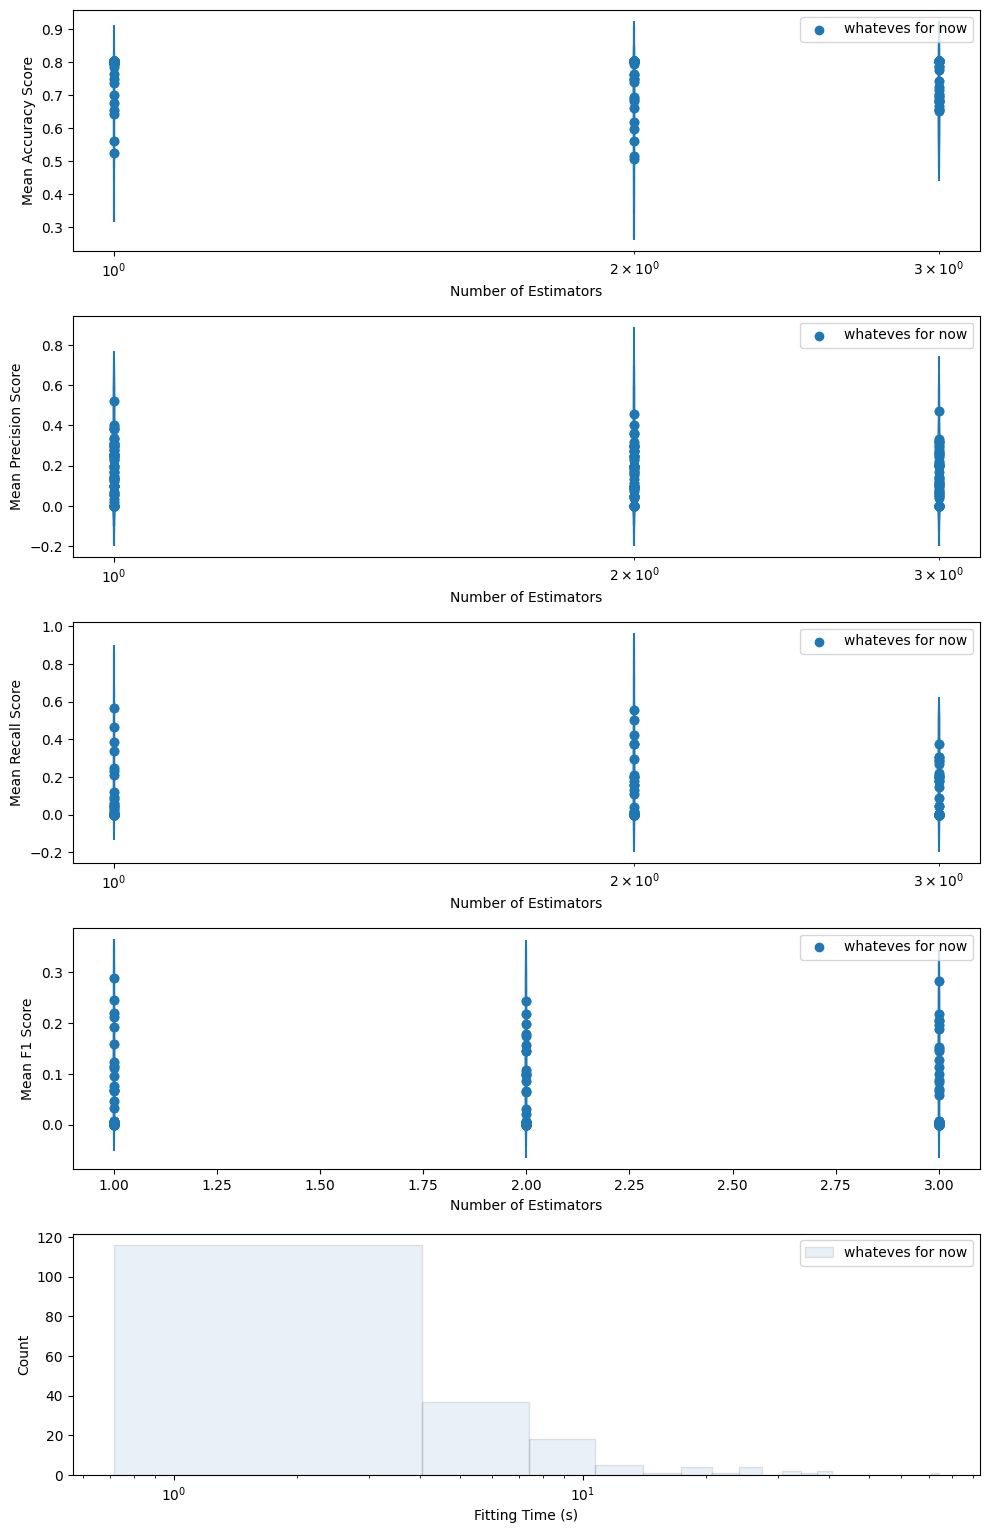

[CV 3/5; 1/192] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd
[CV 3/5; 1/192] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; accuracy: (test=0.803) f1_score: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.7s
[CV 1/5; 3/192] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=400, solver=sgd
[CV 1/5; 3/192] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=400, solver=sgd; accuracy: (test=0.803) f1_score: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   1.0s
[CV 1/5; 4/192] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=400, solver=adam
[CV 1/5; 4/192] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=400, solver=adam; accuracy: (te

In [83]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

    
mlp_classifier = MLPClassifier()

scoring = {
    'accuracy': 'accuracy',  # Default scorer
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50), (100, 100, 100)],
    'activation': ['tanh', 'relu'],  # Common choices for activation functions
    'solver': ['sgd', 'adam'],  # Stochastic gradient descent and Adam optimizer
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'max_iter': [200, 400],  # Maximum number of iterations. The solver iterates until convergence or this number of iterations.
}

grid_search = GridSearchCV(mlp_classifier,
                           param_grid,
                           cv=5,
                           verbose=10,
                           scoring=scoring,
                           refit='recall',
                           n_jobs=-1)

class_weights = compute_sample_weight(class_weight='balanced', y=y)
grid_search.fit(X_opt, y_opt)

clear_output(wait=True)

results = pd.DataFrame(grid_search.cv_results_)
results['ML_model'] = ["MLPClassifier"]*len(results)

for param in param_grid.keys():
    results[f'param_{param}'] = [row['params'][param] for _, row in results.iterrows()]

if cummulative_results is None:
    cummulative_results = results.copy()
else:
    cummulative_results = pd.concat([cummulative_results, results])

fig, ax = plt.subplots(5, figsize=[10, 25/1.62])

best_bw_time = bestbandwidth(results['mean_fit_time'])
min_time, max_time = results['mean_fit_time'].min(), results['mean_fit_time'].max()
nBins_time = int((max_time - min_time)/best_bw_time)
bins_time = np.linspace(min_time, max_time, num = nBins_time)

label = f'whateves for now'
n_estimators = [len(r) for r in results['param_hidden_layer_sizes']]
mean_scores = results['mean_test_accuracy']
std_scores = results['std_test_accuracy']
ax[0].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[0].scatter(n_estimators, mean_scores, label=label)

mean_scores = results['mean_test_precision']
std_scores = results['std_test_precision']
ax[1].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[1].scatter(n_estimators, mean_scores, label=label)

mean_scores = results['mean_test_recall']
std_scores = results['std_test_recall']
ax[2].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[2].scatter(n_estimators, mean_scores, label=label)

mean_scores = results['mean_test_f1_score']
std_scores = results['std_test_f1_score']
ax[3].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[3].scatter(n_estimators, mean_scores, label=label)

ax[4].hist(results['mean_fit_time'], alpha=0.1, edgecolor = 'k', bins=bins_time, label=label)

clear_output()

ax[0].set_xscale('log')
ax[0].set_xlabel('Number of Estimators')
ax[0].set_ylabel('Mean Accuracy Score')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('Number of Estimators')
ax[1].set_ylabel('Mean Precision Score')
ax[1].legend()

ax[2].set_xscale('log')
ax[2].set_xlabel('Number of Estimators')
ax[2].set_ylabel('Mean Recall Score')
ax[2].legend()

ax[4].set_xscale('log')
ax[3].set_xlabel('Number of Estimators')
ax[3].set_ylabel('Mean F1 Score')
ax[3].legend()

ax[4].set_xlabel("Fitting Time (s)")
ax[4].set_ylabel('Count')
ax[4].legend()

fig.tight_layout()

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50)],
    'activation': ['tanh', 'relu'],  # Common choices for activation functions
    'solver': ['sgd', 'adam'],  # Stochastic gradient descent and Adam optimizer
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'max_iter': [200, 400],  # Maximum number of iterations. The solver iterates until convergence or this number of iterations.
}

In [ ]:
results.sort_values('mean_test_recall', inplace=True)
results.dropna(inplace=True)
print("Loading best parameters and defining")
# Initialize the model
best_hidden_layer_sizes = results.iloc[-1]['param_hidden_layer_sizes']
best_activation = results.iloc[-1]['param_activation']
best_solver = results.iloc[-1]['param_solver']
best_alpha = results.iloc[-1]['param_alpha']
best_learning_rate = results.iloc[-1]['param_learning_rate']
best_max_iter = results.iloc[-1]['param_max_iter']

print(f"""Best Parameters:
 - Hidden Layers: {best_hidden_layer_sizes}
 - Activation: {best_activation}
 - Solver {best_solver}
 - Alpha {best_alpha}
 - Learning Rate {best_learning_rate}
 - Max Iterations {best_max_iter}""")

mlp_classifier = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, 
                               activation=best_activation,
                               solver=best_solver,
                               alpha=best_alpha,
                               learning_rate=best_learning_rate,
                               max_iter=best_max_iter)

print("Fitting the model to the training data")

# Train the model
mlp_classifier.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = mlp_classifier.predict(X_test)

# print("Computing cross-validations")
# train_sizes, train_scores, test_scores = learning_curve(
#     mlp_classifier, X, y, cv=5, n_jobs=-1, 
#     train_sizes=np.linspace(.1, 1.0, 10),
#     verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

feature_importances = random_forest_classifier.feature_importances_

features = np.array(ML_columns)  # Assuming ML_columns are your feature names
importances = feature_importances

# Sorting features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=sorted_importances, y=sorted_features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances in RandomForestClassifier")
ax[2].set_xlabel('Importance')
ax[2].set_ylabel('Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

Loading best parameters and defining
Best Parameters:
 - Hidden Layers: (50,)
 - Activation: relu
 - Solver adam
 - Alpha 0.0001
 - Learning Rate constant
 - Max Iterations 200
Fitting the model to the training data


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

ML_columns = [column for column in loans_data.columns if loans_data[column].dtype == int or loans_data[column].dtype == float or loans_data[column].dtype == bool]

sample_data = loans_data.sample(10000)
# Defining inputs and outputs of dataset
X = sample_data[ML_columns].drop('loan_status_num', axis='columns').values
y = np.vstack(sample_data[ML_columns]['loan_status_num'].values)
# Splitting between trainnig and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of training inputs: {X_train.shape}")
print(f"Shape of testing inputs: {X_test.shape}")
print(f"Shape of training outputs: {y_train.shape}")
print(f"Shape of testing outputs: {y_test.shape}")

# Scaling the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(X)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)



In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.01)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

train_sizes, train_scores, test_scores = learning_curve(
    logistic_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

coefficients = np.abs(logistic_model.coef_[0])

# Combining feature names and their corresponding coefficients
features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

features = np.array(features)
coefs = np.array(coefs)

features = features[coefs > 0]
coefs = coefs[coefs > 0]

fig, ax = plt.subplots(1, 3, figsize = [30*1.62, 15])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
ax[2].set_title("Correlation between Loan status and Numeric Features")
ax[2].set_xlabel('Correlation')
ax[2].set_ylabel('Numerical Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

In [ ]:
import sys
import os

import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    # Since we're setting this at the sys level, it should not be overridden
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

import matplotlib
matplotlib.use('Agg')

print("Starting Hyperparameter optimization run for Logistic Model")

n_reps = 100
max_iter = 100000

print(f"Number of repetitions: {n_reps}")

param_dist = {
    'C': [10**i for i in np.linspace(-4, 4, num=100)],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'l1_ratio': np.linspace(0, 1, num=100),
}

logistic_model = LogisticRegression(class_weight='balanced', max_iter=max_iter)

random_search = RandomizedSearchCV(logistic_model, param_distributions=param_dist, n_iter=n_reps, cv=5, random_state=42, verbose=10, error_score=np.nan)

print("Fitting Random Search")
random_search.fit(X_train, y_train)

param_combination_details = []

for i, (params, mean_test_score) in enumerate(zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']), 1):
    try:
        print(f"Model ID: {i}")
        print(f"Parameters: {params}")

        current_model = random_search.best_estimator_.set_params(**params)

        # Calculate learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            current_model, X_train, y_train, cv=5, n_jobs=-1, 
            train_sizes=np.linspace(.1, 1.0, 5))

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        current_model.fit(X_train, y_train)

        y_pred = current_model.predict(X_test)

        coefficients = np.abs(current_model.coef_[0])

        features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

        features = np.array(features)
        coefs = np.array(coefs)

        features = features[coefs > 0]
        coefs = coefs[coefs > 0]
        
        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

        fig, ax = plt.subplots(1, 3, figsize = [30*1.62, 15])

        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
        ax[0].set_title('Confusion Matrix')
        ax[0].set_ylabel('Actual Labels')
        ax[0].set_xlabel('Predicted Labels')

        ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[1].set_title('Learning Curve')
        ax[1].set_xlabel('Training Examples')
        ax[1].set_ylabel('Score')
        ax[1].legend(loc="best")

        sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
        ax[2].set_title("Correlation between Loan status and Numeric Features")
        ax[2].set_xlabel('Correlation')
        ax[2].set_ylabel('Numerical Features')

        fig_path = f"../figures/LogisticRegression_{str(i).zfill(len(str(n_reps)))}.png"
        fig.tight_layout()
        fig.savefig(fig_path)
        plt.close(fig)
        param_combination_details.append({
            'id': i,
            'params': params,
            'accuracy': mean_test_score,
            'figure_path': fig_path
        })
        print(f"Accuracy:{mean_test_score}\n------------------------")
    except:
        print("Likely Bad Combination?")
param_combination_df = pd.DataFrame(param_combination_details)
param_combination_df.to_csv('../data/LogisticRegression_RandomizedSearchCV.csv', index=False)
print(f'FINAL RESULTS')
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

In [ ]:
import matplotlib
matplotlib.use('Agg')
print("Starting Hyperparameter optimization run for Logistic Model")

n_reps = 1000
max_iter = 100000

print(f"Number of repetitions: {n_reps}")

# Define the parameter space for BayesSearchCV
# search_space = {
#     'C': Real(1e-5, 1e5, 'log-uniform'),
#     'solver': Categorical(['liblinear']),
#     'penalty': Categorical(['l2', 'l1']),
#     'l1_ratio': Real(0, 1)
# }
# best ~ 0.65

search_space = {
    'C': Real(1e-5, 1e5, 'log-uniform'),
    'solver': Categorical(['newton-cg']),
    'penalty': Categorical(['l2', None]),
    'l1_ratio': Real(0, 1)
}

def progress_reporter(optim_result):
    # This function can be customized to print or log the information you're interested in.
    # For instance, you can print the current iteration number:
    iteration = len(optim_result.x_iters)
    print(f"Iteration {iteration}/{n_reps}, Current best score: {-optim_result.fun}")

logistic_model = LogisticRegression(class_weight='balanced', max_iter=max_iter)

# Define BayesSearchCV
bayes_search = BayesSearchCV(logistic_model, search_space, n_iter=n_reps, cv=5, random_state=42, verbose=10, n_jobs=-1)

bayes_search.fit(X_train, y_train, callback=progress_reporter)

# Processing results
param_combination_details = []
for i, params in enumerate(bayes_search.cv_results_['params'], 1):
    print(f"Model ID: {i}")
    print(f"Parameters: {params}")

    current_model = bayes_search.best_estimator_.set_params(**params)

    # Calculate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        current_model, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    current_model.fit(X_train, y_train)

    y_pred = current_model.predict(X_test)

    coefficients = np.abs(current_model.coef_[0])

    features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

    features = np.array(features)
    coefs = np.array(coefs)

    features = features[coefs > 0]
    coefs = coefs[coefs > 0]

    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

    fig, ax = plt.subplots(1, 3, figsize = [30*1.62, 15])

    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_ylabel('Actual Labels')
    ax[0].set_xlabel('Predicted Labels')

    ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[1].set_title('Learning Curve')
    ax[1].set_xlabel('Training Examples')
    ax[1].set_ylabel('Score')
    ax[1].legend(loc="best")

    sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
    ax[2].set_title("Correlation between Loan status and Numeric Features")
    ax[2].set_xlabel('Correlation')
    ax[2].set_ylabel('Numerical Features')

    fig_path = f"../figures/LogisticRegression_BayesSearchCV_{str(i).zfill(len(str(n_reps)))}.png"
    fig.tight_layout()
    fig.savefig(fig_path)
    plt.close(fig)
    param_combination_details.append({
        'id': i,
        'params': params,
        'accuracy': np.mean(test_scores_mean),
        'figure_path': fig_path
    })
    print(f"Accuracy:{np.mean(test_scores_mean)}\n------------------------")
param_combination_df = pd.DataFrame(param_combination_details)
param_combination_df.to_csv('../data/LogisticRegression_BayesSearchCV.csv', index=False)
print(f'FINAL RESULTS')
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best score: {bayes_search.best_score_}")

In [ ]:
import matplotlib
import sys
import os
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import make_scorer
matplotlib.use('Agg')
print("Starting Hyperparameter optimization run for Logistic Model")

import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    # Since we're setting this at the sys level, it should not be overridden
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses
    
n_reps = 100
max_iter = 100000

print(f"Number of repetitions: {n_reps}")

# Define the parameter space for BayesSearchCV
search_space = {
    'C': Real(1e-4, 1e4, 'log-uniform'),
    'solver': Categorical(['liblinear', 'saga']),
    'penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'l1_ratio': Real(0, 1)
}

logistic_model = LogisticRegression(class_weight='balanced', max_iter=max_iter)

class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, penalty='l2', max_iter=100, solver='lbfgs', l1_ratio=None):
        # Explicitly list parameters
        self.C = C
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        self.l1_ratio = l1_ratio

    def fit(self, X, y):
        # Use the parameters in LogisticRegression
        self.model = LogisticRegression(
            C=self.C, 
            penalty=self.penalty, 
            max_iter=self.max_iter, 
            solver=self.solver, 
            l1_ratio=self.l1_ratio
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        params = self.model.get_params()

        # Define invalid combinations
        if params['solver'] == 'liblinear' and params['penalty'] == 'elasticnet':
            return -np.inf  # Large negative value for invalid combination
        if params['solver'] == 'liblinear' and params['penalty'] is None:
            return -np.inf
        if params['penalty'] == 'elasticnet' and params['solver'] != 'saga':
            return np.inf

        # Compute the score only if the combination is valid
        return accuracy_score(y, y_pred)

logistic_model_instance = CustomLogisticRegression()

# BayesSearchCV with custom scorer
bayes_search = BayesSearchCV(
    estimator=logistic_model_instance, 
    search_spaces=search_space, 
    n_iter=n_reps, 
    cv=5, 
    random_state=42, 
    n_jobs=-1
)

np.int = int
bayes_search.fit(X_train, y_train)

# Processing results
param_combination_details = []
for i, params in enumerate(bayes_search.cv_results_['params'], 1):
    try:
        print(f"Model ID: {i}")
        print(f"Parameters: {params}")

        current_model = bayes_search.best_estimator_.set_params(**params)

        # Calculate learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            current_model, X_train, y_train, cv=5, n_jobs=-1, 
            train_sizes=np.linspace(.1, 1.0, 5))

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        current_model.fit(X_train, y_train)

        y_pred = current_model.predict(X_test)

        coefficients = np.abs(current_model.coef_[0])

        features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

        features = np.array(features)
        coefs = np.array(coefs)

        features = features[coefs > 0]
        coefs = coefs[coefs > 0]
        
        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

        fig, ax = plt.subplots(1, 3, figsize = [30*1.62, 15])

        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
        ax[0].set_title('Confusion Matrix')
        ax[0].set_ylabel('Actual Labels')
        ax[0].set_xlabel('Predicted Labels')

        ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[1].set_title('Learning Curve')
        ax[1].set_xlabel('Training Examples')
        ax[1].set_ylabel('Score')
        ax[1].legend(loc="best")

        sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
        ax[2].set_title("Correlation between Loan status and Numeric Features")
        ax[2].set_xlabel('Correlation')
        ax[2].set_ylabel('Numerical Features')

        fig_path = f"../figures/LogisticRegression_BayesSearchCV_{str(i).zfill(len(str(n_reps)))}.png"
        fig.tight_layout()
        fig.savefig(fig_path)
        plt.close(fig)
        param_combination_details.append({
            'id': i,
            'params': params,
            'accuracy': mean_test_score,
            'figure_path': fig_path
        })
        print(f"Accuracy:{mean_test_score}\n------------------------")
    except:
        print("Likely Bad Combination?")
param_combination_df = pd.DataFrame(param_combination_details)
param_combination_df.to_csv('../data/LogisticRegression_BayesSearchCV.csv', index=False)
print(f'FINAL RESULTS')
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best score: {bayes_search.best_score_}")

In [ ]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np

# Define the domain (parameter space)
domain = [{'name': 'C', 'type': 'continuous', 'domain': (1e-4, 1e4), 'transformation': 'log'},
          {'name': 'solver', 'type': 'categorical', 'domain': (0, 1)},
          {'name': 'penalty', 'type': 'categorical', 'domain': (0, 1, 2, 3)},
          {'name': 'l1_ratio', 'type': 'continuous', 'domain': (0, 1)}]

# Mapping for categorical variables
solver_mapping = {0: 'liblinear', 1: 'saga'}
penalty_mapping = {0: 'l2', 1: 'l1', 2: 'elasticnet', 3: None}


def model_score(model, X_train, X_test, y_train, y_test, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
    logistic_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    return test_scores_mean

def is_valid_combination(params):
    if params['solver'] == 'liblinear' and (params['penalty'] == 'elasticnet' or params['l1_ratio'] is not None):
        return False
    return True


# Objective function
def objective_function(x):
    params = {
        'C': x[0][0],
        'solver': solver_mapping[int(x[0][1])],
        'penalty': penalty_mapping[int(x[0][2])],
        'l1_ratio': x[0][3]
    }
    if not is_valid_combination(params):
        return np.nan
    model = LogisticRegression(class_weight='balanced', max_iter=max_iter, **params)
    return -model_score(model, X_train, X_test, y_train, y_test)  # Assuming lower is better

bo = BayesianOptimization(f=objective_function, domain=domain, model_type='GP', acquisition_type='EI', maximize=True)
bo.run_optimization(max_iter=50)

print(bo.x_opt)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest model
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importances
feature_importances = abs(rf_model.feature_importances_)

# Combining feature names and their corresponding importances
features, importances = zip(*sorted(zip(ML_columns, feature_importances), key=lambda x: x[1], reverse=True))

# Plotting
fig, ax = plt.subplots(1, 3, figsize=[15*1.62, 5])

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

# Learning Curve
ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

# Feature Importances
sns.barplot(x=importances, y=features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances")
ax[2].set_xlabel('Relative Importance')
ax[2].set_ylabel('Features')

fig.tight_layout()

In [ ]:
from sklearn.neural_network import MLPClassifier

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize the MLPClassifier model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                          max_iter=100, random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred = mlp_model.predict(X_test)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    mlp_model, X_train, y_train, cv=5, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=[10*1.62, 5])  # Reduced to 1x2 layout

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

# Learning Curve
ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

fig.tight_layout()
